# Clasificación de curvas de acuerdo a su forma utilizando aprendizaje no supervisado


En este cuaderno de trabajo, se aplicarán algoritmos de **aprendizaje no supervisado** para la clasificación de curvas de carga representativas de clientes. Previamente, se realizó un **proceso ETL** en el que se consolidaron datos de múltiples clientes en un único conjunto de datos anual. Estos datos fueron almacenados en **MongoDB** y contienen mediciones de potencia aparente cada **30 minutos**, desde las **00:00 hasta las 23:30**.

El objetivo principal de este análisis es **agrupar las curvas de carga según su forma**, sin que influya el desplazamiento en el eje Y. Para ello, se realizarán una serie de transformaciones y ajustes antes de aplicar los algoritmos de clustering.

### Algoritmos de Clustering Utilizados
Se han seleccionado los siguientes algoritmos de **aprendizaje no supervisado**:

- **K-Means** 🟢  
- **Gaussian Mixture Model (GMM)** 🔵  
- **BIRCH** 🟡  
- **Spectral Clustering** 🟣  

Cada uno de estos algoritmos se ajustará y evaluará para determinar cuál realiza una mejor agrupación de las curvas según su forma.

---

### 0.- Librerías y Funciones a Utilizar  

Se importan las librerías necesarias para el procesamiento de datos, visualización y clustering.

- Librerías Principales  
    - `numpy`, `pandas` → Manejo y transformación de datos.  
    - `matplotlib` → Gráficos y visualización.  
    - `sklearn` → Algoritmo de clustering y métricas.  
    - `pymongo` → Conexión con MongoDB.  

- Algoritmos de Clustering  
    - `KMeans`, `GaussianMixture`, `BIRCH`, `SpectralClustering`.  

- Funciones Auxiliares  
    - Ajuste de curvas al origen *(0,0)*.  
    - Visualización de resultados.
    - Hyperparametrización para los algoritmos
    - Agrupación para cada tipo de algoritmos
    - Evaluar calidad de las agrupaciones

In [1]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import SpectralClustering, KMeans, Birch
from sklearn.mixture import GaussianMixture
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from pymongo import MongoClient
from dotenv import load_dotenv
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import shutil
import os

warnings.filterwarnings("ignore")

In [2]:
def obtener_cliente_db():
    # Cargar las variables del archivo .env
    load_dotenv()

    # Obtener las credenciales y el cluster de MongoDB
    username = os.getenv("DB_USER_T")
    password = os.getenv("DB_PASS_T")
    cluster = os.getenv("DB_CLUSTER_T")

    # Construir la uri con las credenciales
    uri = f"mongodb+srv://{username}:{password}@{cluster.lower()}.gypwd.mongodb.net/?retryWrites=true&w=majority&appName={cluster}"

    # Crear un cliente y conectarlo al servidor
    client = MongoClient(uri, 
                        server_api=ServerApi('1'),
                        connectTimeoutMS=60000,
                        socketTimeoutMS=60000,
                        serverSelectionTimeoutMS=60000,
                        tls=True)

    # Si el cliente existe, retornarlo
    if client is not None:
        return client

In [3]:
def ajustar_curva_al_origen(datos_curvas):

    # Crear una copia del arreglo original de las curvas
    curvas_ajustadas = datos_curvas.copy()

    # Iterar sobre cada curva
    for curva in curvas_ajustadas:
        # Obtener el primer dato de cada curva
        primer_dato = curva[0]

        # Modificar los datos de la curva para que el primero siempre empiece en (0,0)
        for i in range(len(curva)):
            curva[i] = curva[i] - primer_dato

    # Retornar todas las curvas con el ajuste realizado
    return curvas_ajustadas

In [98]:
def graficar_clusters(curves_data, labels, n=5):
    unique_clusters = np.unique(labels)
    
    # Crear una figura con el número de subgráficos correspondientes al número de clústeres
    fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(8, 3.5 * len(unique_clusters)), sharex=True)
    
    if len(unique_clusters) == 1:
        axes = [axes]  # Si solo hay un clúster, hacer que axes sea iterable para mantener el formato
    
    # Para cada clúster, graficar las curvas
    for idx, cluster in enumerate(unique_clusters):
        # Seleccionar las curvas pertenecientes al clúster
        curvas_cluster = curves_data[labels == cluster]

        # Tomar hasta 'n' curvas para graficar
        curvas_a_graficar = curvas_cluster[:min(n, len(curvas_cluster))]
        
        for curva in curvas_a_graficar:
            axes[idx].plot(curva, alpha=0.7, linestyle='--')  # Graficar cada curva con transparencia

        axes[idx].set_title(f'Curvas agrupadas en el Clúster {cluster}')
        axes[idx].set_xlabel('Hora del día')
        axes[idx].set_ylabel('Potencia aparente escalada')
        axes[idx].set_yticks(np.arange(0, 1, 0.1))
        axes[idx].grid(True)

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def graficar_curva_tipo_cluster(curves_data, labels):
    unique_clusters = np.unique(labels)
    plt.figure(figsize=(10, 6))
    
    # Colores para cada cluster
    colors = plt.cm.tab10(range(len(unique_clusters)))  # hasta 10 colores distintos
    
    for idx, cluster in enumerate(unique_clusters):
        # Seleccionar las curvas pertenecientes al clúster
        curvas_cluster = curves_data[labels == cluster]
        
        # Calcular la curva media
        curva_media = np.mean(curvas_cluster, axis=0)
        
        # Graficar la curva media
        plt.plot(curva_media, label=f'Clúster {cluster}', color=colors[idx])
    
    plt.title('Curvas tipo por clúster')
    plt.xlabel('Hora del día')
    plt.ylabel('Potencia aparente escalada')
    plt.xticks(np.arange(0, len(curva_media), step=2))  # cada 2 horas, ajusta según tus datos
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [225]:
def evaluate_clustering_models(data, param_grid, rand_state=42):
    best_models = {}
    results = []

    for model_name, params in param_grid.items():
        param_combinations = list(product(*params.values()))
        param_keys = list(params.keys())

        best_score = -1
        best_params = None
        best_model = None

        for param_set in param_combinations:
            param_dict = dict(zip(param_keys, param_set))

            # Crear el modelo según su tipo
            if model_name == "KMeans":
                model = KMeans(**param_dict, random_state=rand_state)
            elif model_name == "GaussianMixture":
                model = GaussianMixture(**param_dict, random_state=rand_state)
            elif model_name == "Birch":
                model = Birch(**param_dict)
            elif model_name == "SpectralClustering":
                model = SpectralClustering(**param_dict, random_state=rand_state)

            # Entrenar el modelo y obtener etiquetas
            try:
                labels = model.fit_predict(data)

                # Calcular métricas
                silhouette = silhouette_score(data, labels)
                calinski_harabasz = calinski_harabasz_score(data, labels)
                davies_bouldin = davies_bouldin_score(data, labels)
                corr_ic = calcular_correlacion_intra_cluster(data, labels)

                # Guardar resultados
                results.append((model_name, param_dict, silhouette, calinski_harabasz, davies_bouldin))

                # Actualizar mejor modelo basado en Silhouette Score (puedes cambiar este criterio)
                if corr_ic > best_score:
                    best_score = corr_ic
                    best_params = param_dict
                    best_model = model

            except:
                continue  # Si hay error, seguimos con la siguiente combinación

        # Guardar el mejor modelo para este tipo
        best_models[model_name] = {
            "model": best_model,
            "params": best_params,
            "Correlación intra-cluster promedio": best_score
        }

    return best_models, results


In [220]:
def apply_clustering(parametros_opt, datos_curvas, num_random_state=42):
    # Función para aplicar clustering
    kmeans = KMeans(**parametros_opt["KMeans"], random_state=num_random_state).fit(datos_curvas)
    gmm = GaussianMixture(**parametros_opt["GaussianMixture"], random_state=num_random_state).fit(datos_curvas)
    birch = Birch(**parametros_opt["Birch"]).fit(datos_curvas)
    spectral = SpectralClustering(**parametros_opt["SpectralClustering"], random_state=num_random_state, assign_labels='kmeans').fit(datos_curvas)
    
    return {
        'KMeans': kmeans.labels_,
        'GaussianMixture': gmm.predict(datos_curvas),
        'Birch': birch.labels_,
        'SpectralClustering': spectral.labels_
    }

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluar_clustering(curvas_ajustadas_origen, clusters):
    resultados = {
        "Métrica": [
            "Silhouette Score",
            "SSE",
            "Davies-Bouldin Index",
            "Calinski-Harabasz Index",
            "Correlación intra-clúster promedio"
        ]
    }
    
    for algoritmo, labels in clusters.items():
        labels = np.array(labels)
        
        # Puntaje de silueta
        silhouette_avg = silhouette_score(curvas_ajustadas_origen, labels)
        
        # Davies-Bouldin Index (DBI)
        dbi = davies_bouldin_score(curvas_ajustadas_origen, labels)
        
        # Calinski-Harabasz Index (CHI)
        chi = calinski_harabasz_score(curvas_ajustadas_origen, labels)
        
        # Sum of Squared Errors (SSE)
        unique_labels = np.unique(labels)
        centroids = np.array([curvas_ajustadas_origen[labels == lbl].mean(axis=0) for lbl in unique_labels])
        sse = compute_sse(curvas_ajustadas_origen, labels, centroids)
        
        # Correlación intra-clúster
        corr_intra = calcular_correlacion_intra_cluster(curvas_ajustadas_origen, labels)
        
        resultados[algoritmo] = [silhouette_avg, sse, dbi, chi, corr_intra]
    
    return pd.DataFrame(resultados)

def compute_sse(X, labels, centroids):
    sse = 0
    for i in range(len(centroids)):
        cluster_points = X[np.array(labels) == i]
        if len(cluster_points) > 0:
            sse += np.sum((cluster_points - centroids[i]) ** 2)
    return sse

def calcular_correlacion_intra_cluster(curves_data, labels):
    """
    Calcula la correlación promedio de cada curva con la curva media de su clúster.
    Maneja casos donde hay clústeres vacíos o con un solo punto.
    """
    unique_clusters = np.unique(labels)
    correlaciones = []

    for cluster in unique_clusters:
        curvas_cluster = curves_data[labels == cluster]

        # Calcular curva media
        curva_media = np.mean(curvas_cluster, axis=0)

        # Evitar división por cero en curvas constantes
        for curva in curvas_cluster:
            if np.std(curva) == 0 or np.std(curva_media) == 0:
                corr = 1.0  # Considerar correlación perfecta si no hay variación
            else:
                corr = np.corrcoef(curva, curva_media)[0, 1]
            correlaciones.append(corr)


    return np.nanmean(correlaciones)

In [79]:
def elbow_method(data, k_range=(1, 10)):
    """
    Aplica el método del codo y grafica la inercia y la distorsión para diferentes valores de k.
    
    Parámetros:
        data (array-like): Datos a agrupar.
        k_range (tuple): Rango de valores de k a evaluar (mínimo, máximo).
    """
    ks = list(range(k_range[0], k_range[1] + 1))
    inertias = []
    distortions = []
    
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init="k-means++")
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        # Distorsión: distancia promedio al centroide
        distortion = np.mean(np.min(
            np.linalg.norm(data[:, np.newaxis] - kmeans.cluster_centers_, axis=2), axis=1))
        distortions.append(distortion)
    
    plt.figure(figsize=(14, 6))
    
    # Gráfico de Inercia
    plt.subplot(1, 2, 1)
    plt.plot(ks, inertias, marker='o', linestyle='-')
    plt.xticks(np.arange(k_range[0], k_range[1]+1, 1))
    plt.xlabel('Número de Clústeres (k)')
    plt.ylabel('Inercia')
    plt.title('Método del Codo: Inercia')
    plt.grid()

    # Gráfico de Distorsión
    plt.subplot(1, 2, 2)
    plt.plot(ks, distortions, marker='s', color='orange', linestyle='-')
    plt.xticks(np.arange(k_range[0], k_range[1]+1, 1))
    plt.xlabel('Número de Clústeres (k)')
    plt.ylabel('Distorsión promedio')
    plt.title('Método del Codo: Distorsión')
    plt.grid()
    
    plt.tight_layout()
    plt.show()


### 1.- Obtención y Preprocesamiento de Datos
- **Obtención de datos** desde la base de datos MongoDB.
- **Ajuste de curvas** para que todas comiencen desde el punto origen **(0,0)**.  
   - Esto es importante porque algunas curvas, aunque tienen la misma forma, están desplazadas en el eje Y (potencia aparente), lo que podría afectar la agrupación.

Nota: Los datos de las curvas ya fueron **normalizados** y **escalados** cuando se realizó previamente el proceso ETL.

In [9]:
# Obtener cliente para conectar a la db
db_cliente = obtener_cliente_db()

# Obtener los registros de las curvas
cursor = db_cliente.CurvasTipo.CurvasTipo_15m_v2.find({}, {"_id": 0})
df_registros_curvas = pd.DataFrame(list(cursor))
df_registros_curvas

Cliente     00:00     00:15     00:30     00:45  \
0                             1699791  0.006641  0.006721  0.006521  0.005803   
1                             1132611  0.081502  0.066426  0.052880  0.050020   
2                            90001164  0.401711  0.384288  0.361851  0.366764   
3                            10016608  0.854030  0.860039  0.830305  0.837424   
4                            90002274  0.780804  0.824971  0.831780  0.820684   
..                                ...       ...       ...       ...       ...   
382                        SIGMAPLAST  0.629019  0.630376  0.633878  0.628827   
383                          SINTOFIL  0.570382  0.585197  0.573659  0.597055   
384  SOCIEDAD INDUSTRIAL RELI  CYRANO  0.507827  0.548428  0.602141  0.641924   
385                    TEXTILES TEXSA  0.649134  0.655870  0.673144  0.686085   
386                   VICUNHA ECUADOR  0.018601  0.016489  0.028610  0.032117   

        01:00     01:15     01:30     01:45     02:00  ...     21:30  \
0    0.006295  0.006814  0.006193  0.006814  0.006778  ...  0.007477   
1    0.048880  0.049070  0.045808  0.045223  0.045371  ...  0.169567   
2    0.380571  0.394248  0.395500  0.397604  0.413474  ...  0.362813   
3    0.835443  0.828038  0.830388  0.839721  0.834598  ...  0.864170   
4    0.824391  0.835201  0.801928  0.818192  0.805883  ...  0.663551   
..        ...       ...       ...       ...       ...  ...       ...   
382  0.628891  0.645276  0.620338  0.625429  0.605990  ...  0.714449   
383  0.576146  0.579117  0.577594  0.575732  0.573957  ...  0.718854   
384  0.676887  0.664849  0.604600  0.519819  0.460527  ...  0.143328   
385  0.654700  0.630197  0.620000  0.622630  0.569756  ...  0.658813   
386  0.038422  0.046931  0.032595  0.044854  0.015252  ...  0.235963   

        21:45     22:00     22:15     22:30     22:45     23:00     23:15  \
0    0.007086  0.008579  0.007074  0.007934  0.006692  0.006564  0.007299   
1    0.168023  0.160208  0.143137  0.127647  0.127833  0.128325  0.122728   
2    0.323424  0.331992  0.408344  0.434022  0.442570  0.448411  0.444237   
3    0.826169  0.786728  0.777121  0.819110  0.813144  0.852251  0.857946   
4    0.599305  0.555315  0.552093  0.568132  0.581777  0.623256  0.693446   
..        ...       ...       ...       ...       ...       ...       ...   
382  0.731757  0.722260  0.691284  0.708349  0.708756  0.718092  0.726780   
383  0.682750  0.618568  0.668834  0.652609  0.609928  0.658959  0.648654   
384  0.236751  0.309762  0.366178  0.461476  0.496907  0.532044  0.538810   
385  0.661239  0.658601  0.646816  0.667399  0.659044  0.700041  0.704060   
386  0.141392  0.092120  0.123175  0.128275  0.147159  0.176647  0.147915   

        23:30     23:45  
0    0.006337  0.007301  
1    0.121205  0.123844  
2    0.445044  0.443231  
3    0.860029  0.867627  
4    0.736397  0.793248  
..        ...       ...  
382  0.729823  0.736136  
383  0.672968  0.686380  
384  0.510710  0.507754  
385  0.703403  0.681430  
386  0.163142  0.131872  

[387 rows x 97 columns]

In [10]:
curves_data = df_registros_curvas.iloc[:,1:].values
curves = df_registros_curvas.values

In [11]:
curvas_ajustadas_origen = ajustar_curva_al_origen(curves_data)

### 2.- Método del Codo para Número Óptimo de Clústers

Se ha definido inicialmente **4 clústers**, ya que se identificaron cuatro formas representativas en las curvas anuales. Sin embargo, para validar esta elección, se aplicará el **método del codo**.

Pasos:
- Ejecutar **K-Means** para distintos valores de \( k \) (2 a 20).
- Calcular la **Suma de Errores Cuadráticos (SSE)**.
- Graficar la curva **SSE vs. \( k \)** y detectar el "codo".

Este análisis permitirá verificar si 4 realmente es un número adecuado o si es necesario ajustarlo.

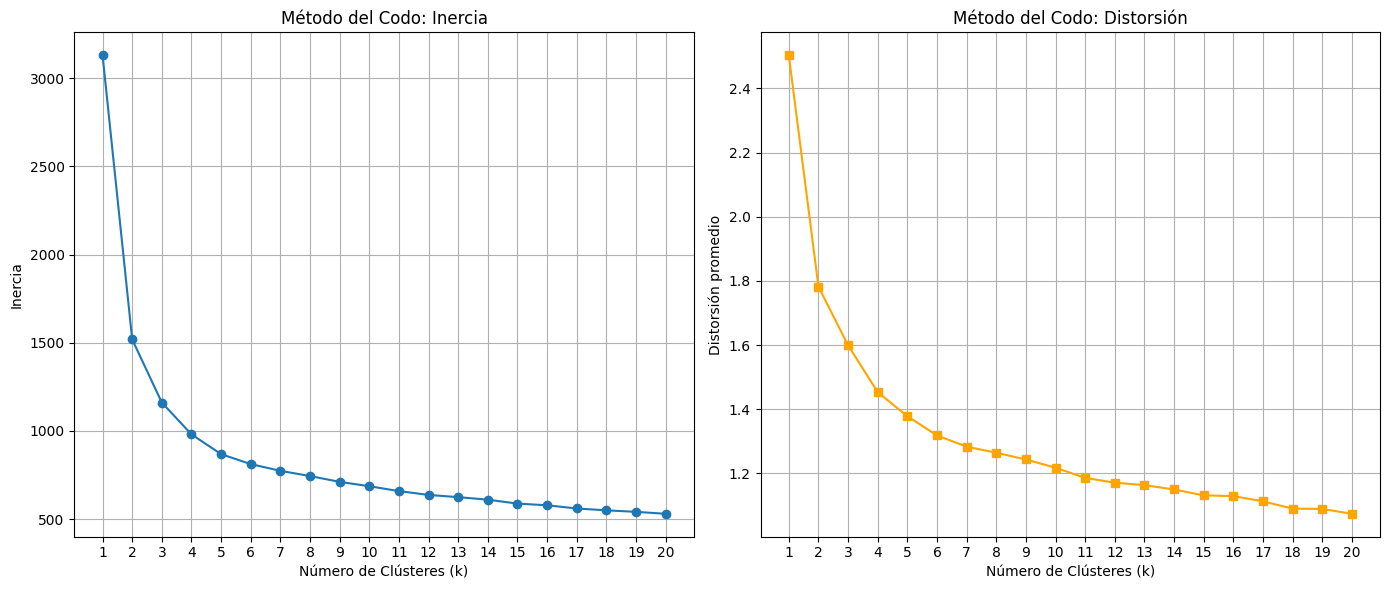

In [80]:
elbow_method(curvas_ajustadas_origen, k_range=(1, 20))

Como se pude apreciar, a partir de k=4, la inercia comienza a minimizarse, formando una especie de 'codo', por lo que podemos asegurar que es un valor bueno e incluso óptimo para el número de agrupaciones que vamos a realizar.

### 3.- Optimización de Hiperparámetros
Para seleccionar los mejores parámetros para cada algoritmo, se definirá un **diccionario de hiperparámetros**, donde:

- Cada clave representa un algoritmo.
- Cada valor es un conjunto de parámetros que puede tomar dicho algoritmo.

Se explorarán combinaciones de hiperparámetros para encontrar la configuración **óptima**.

In [204]:
# Definir los hiperparámetros a probar por cada algoritmo de agrupación
param_grid = {
    "KMeans": {
        "n_clusters": [4],
        "init": ["k-means++", "random"],
        "n_init": [1, 5, 10, 20, 30, 40, 50]
    },
    "GaussianMixture": {
        "n_components": [4],
        "covariance_type": ["full", "diag", "spherical", "tied"],
        "n_init": [1, 5, 10, 20, 30]
    },
    "Birch": {
        "n_clusters": [4],
        "threshold": [0.05, 0.075, 0.1, 0.15, 0.2],
        "branching_factor": [10, 20, 30, 40, 50, 75, 100]
    },
    "SpectralClustering": {
        "n_clusters": [4],
        "affinity": ["nearest_neighbors"],
        "n_neighbors": [4, 6, 8, 10, 15, 25, 35],
        "eigen_solver": ["arpack", "amg"]
    }
}


In [205]:
best_models, results = evaluate_clustering_models(curvas_ajustadas_origen, param_grid)

In [206]:
dict_parametros_optimos = {}

for model_name, info in best_models.items():
    dict_parametros_optimos[model_name] = info["params"]
    print(f"Mejor configuración para {model_name}:")
    print(f"- Parámetros: {info['params']}")
    print(f"- Silhouette Score: {info['silhouette_score']:.4f}")
    print("")

Mejor configuración para KMeans:
- Parámetros: {'n_clusters': 4, 'init': 'random', 'n_init': 10}
- Silhouette Score: 0.7448

Mejor configuración para GaussianMixture:
- Parámetros: {'n_components': 4, 'covariance_type': 'full', 'n_init': 1}
- Silhouette Score: 0.7443

Mejor configuración para Birch:
- Parámetros: {'n_clusters': 4, 'threshold': 0.1, 'branching_factor': 10}
- Silhouette Score: 0.7424

Mejor configuración para SpectralClustering:
- Parámetros: {'n_clusters': 4, 'affinity': 'nearest_neighbors', 'n_neighbors': 6, 'eigen_solver': 'arpack'}
- Silhouette Score: 0.7480



### 4.- Aplicación de los Algoritmos de Clustering
Una vez seleccionados los hiperparámetros óptimos, se procederá a **agrupar las curvas** con cada algoritmo y se analizarán los resultados.

In [213]:
print(dict_parametros_optimos)

{'KMeans': {'n_clusters': 4, 'init': 'random', 'n_init': 10}, 'GaussianMixture': {'n_components': 4, 'covariance_type': 'full', 'n_init': 1}, 'Birch': {'n_clusters': 4, 'threshold': 0.1, 'branching_factor': 10}, 'SpectralClustering': {'n_clusters': 4, 'affinity': 'nearest_neighbors', 'n_neighbors': 6, 'eigen_solver': 'arpack'}}


In [221]:
clusters = apply_clustering(dict_parametros_optimos, curvas_ajustadas_origen)

In [222]:
print(np.bincount(clusters["KMeans"]))
print(np.bincount(clusters["GaussianMixture"]))
print(np.bincount(clusters["Birch"]))
print(np.bincount(clusters["SpectralClustering"]))

[113  28  91 155]
[ 27 149 119  92]
[165 109  32  81]
[ 89 131 141  26]


### 5.- Visualización de Resultados
Para interpretar las agrupaciones, se utilizarán dos funciones de visualización:

- **Curva representativa por clúster**  
   - Se graficará una curva promedio o representativa por cada grupo identificado.

- **Gráfico con todas las curvas de cada clúster**  
   - Se visualizarán todas las curvas pertenecientes a un mismo clúster en un solo gráfico para evaluar la cohesión de los grupos formados.

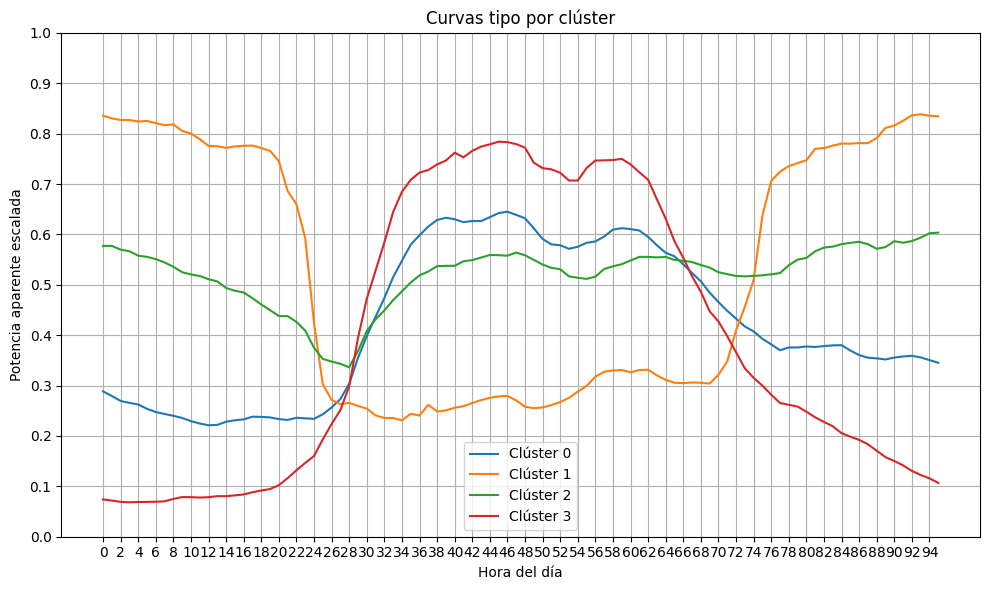

In [226]:
graficar_curva_tipo_cluster(curves_data, clusters["KMeans"])

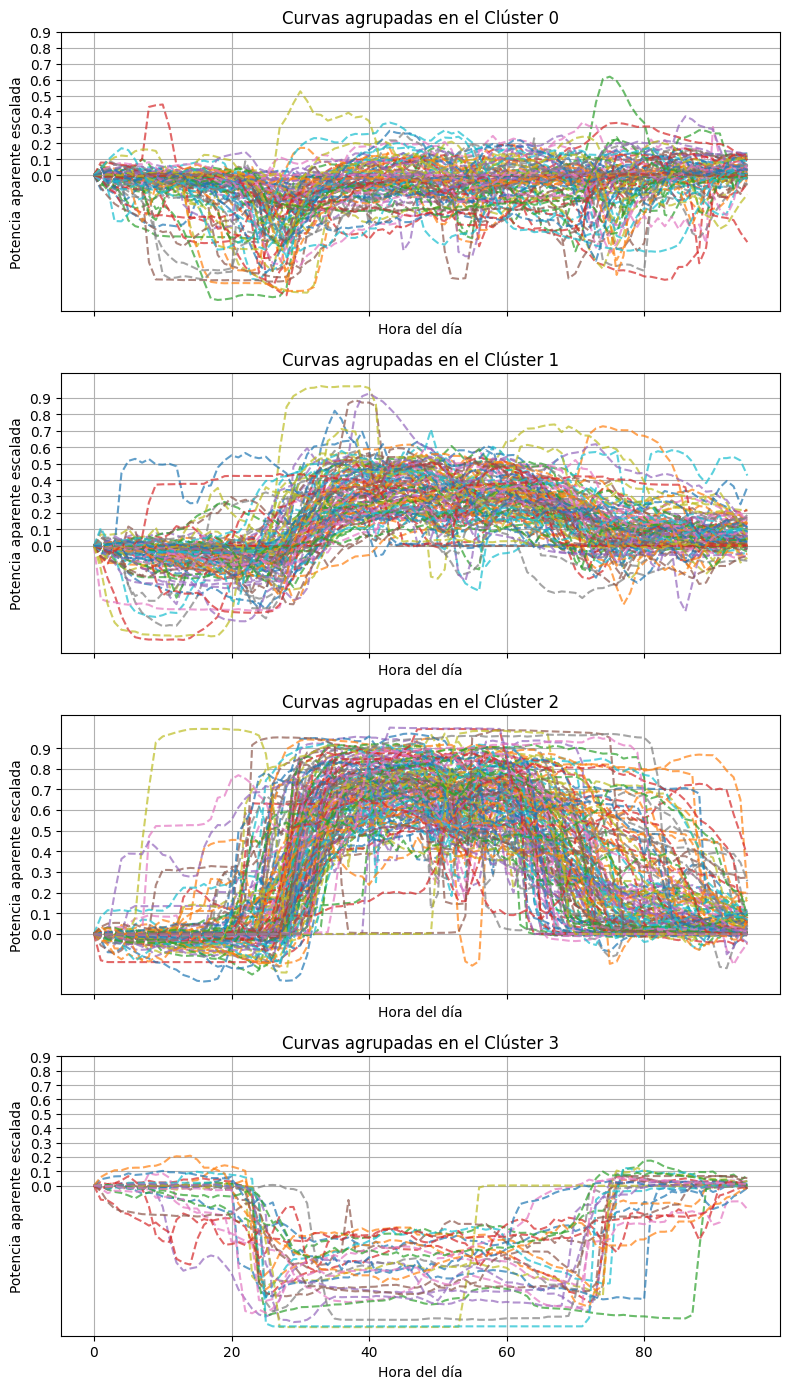

In [172]:
graficar_clusters(curvas_ajustadas_origen, clusters["KMeans"], 200)

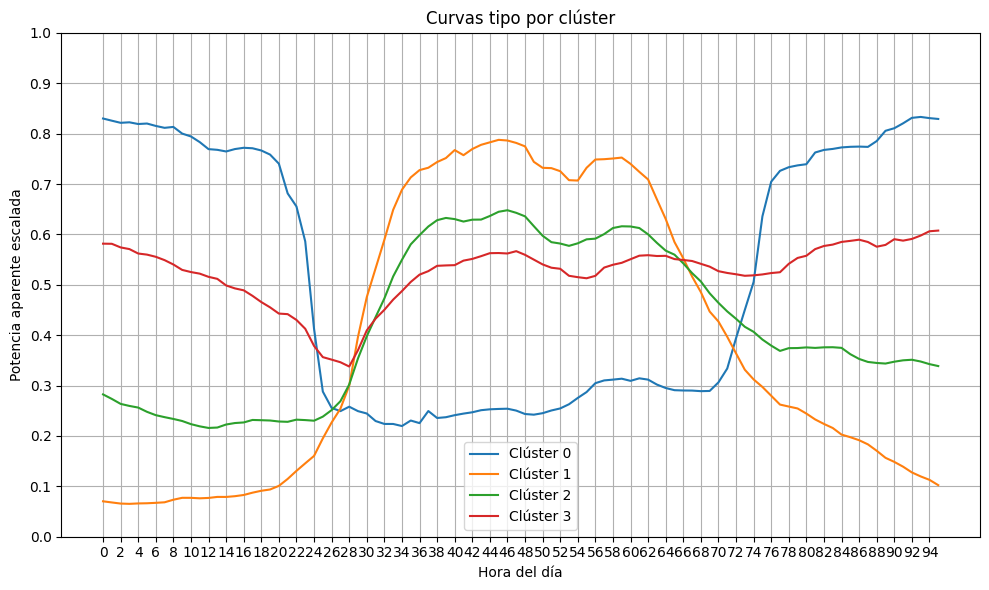

In [227]:
graficar_curva_tipo_cluster(curves_data, clusters["GaussianMixture"])

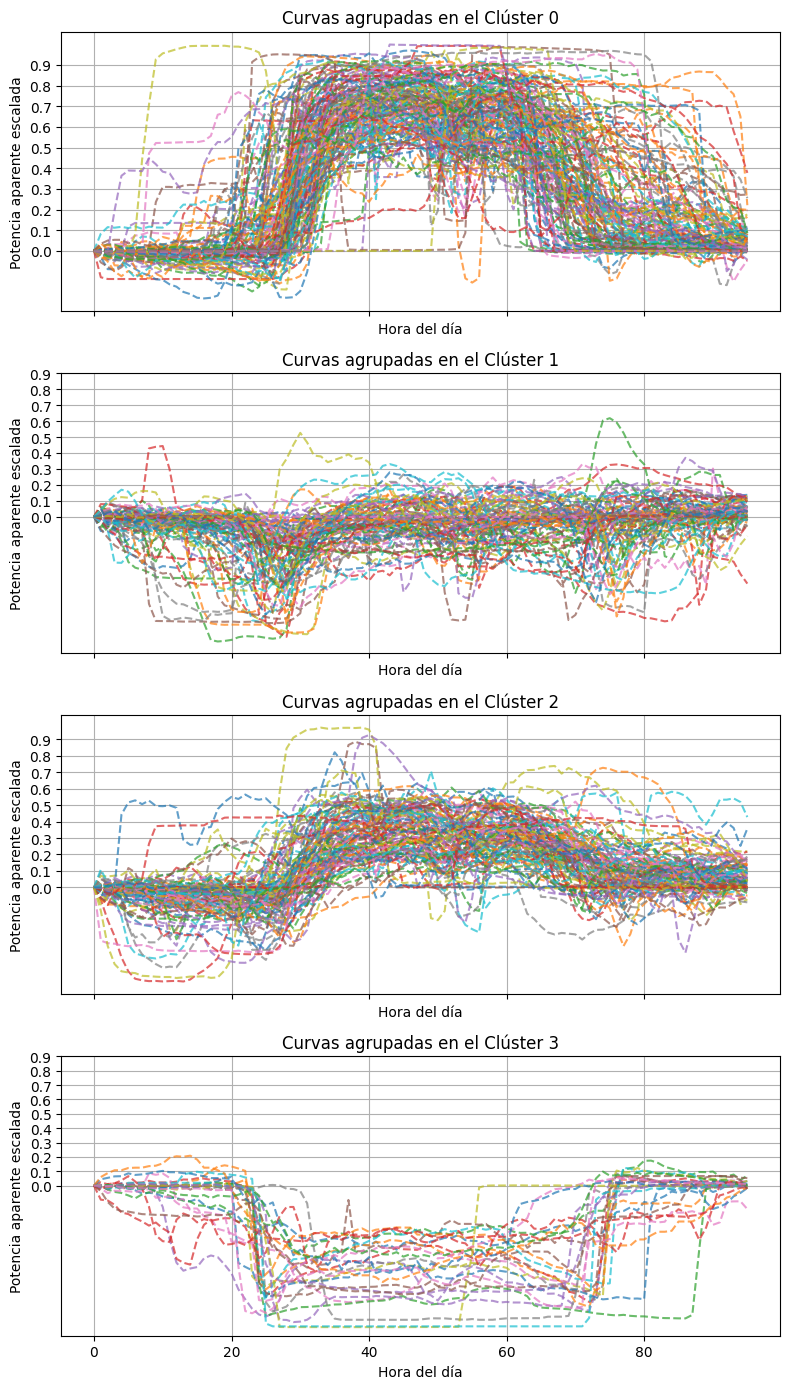

In [174]:
graficar_clusters(curvas_ajustadas_origen, clusters["GaussianMixture"], 200)

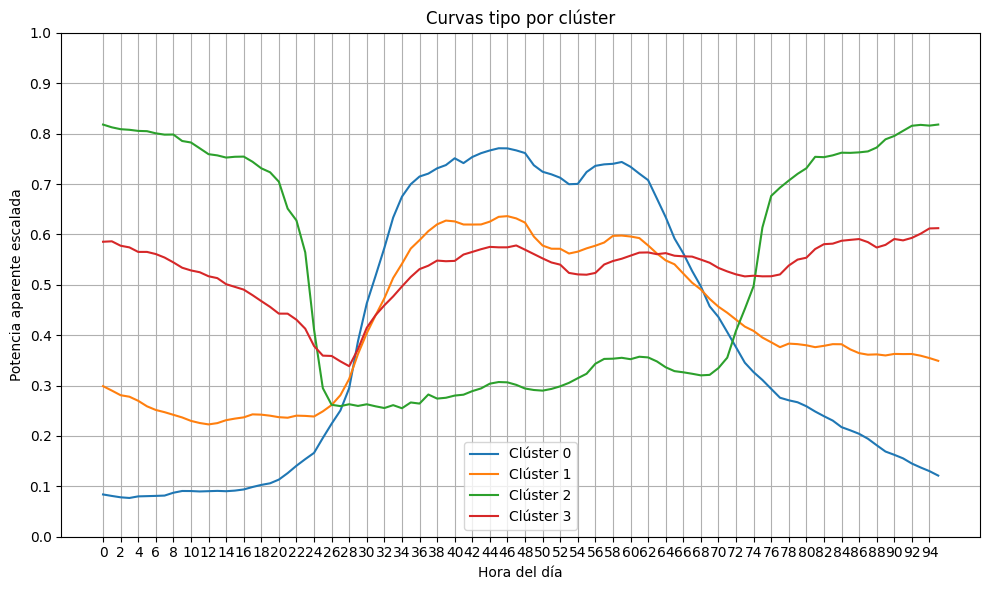

In [228]:
graficar_curva_tipo_cluster(curves_data, clusters["Birch"])

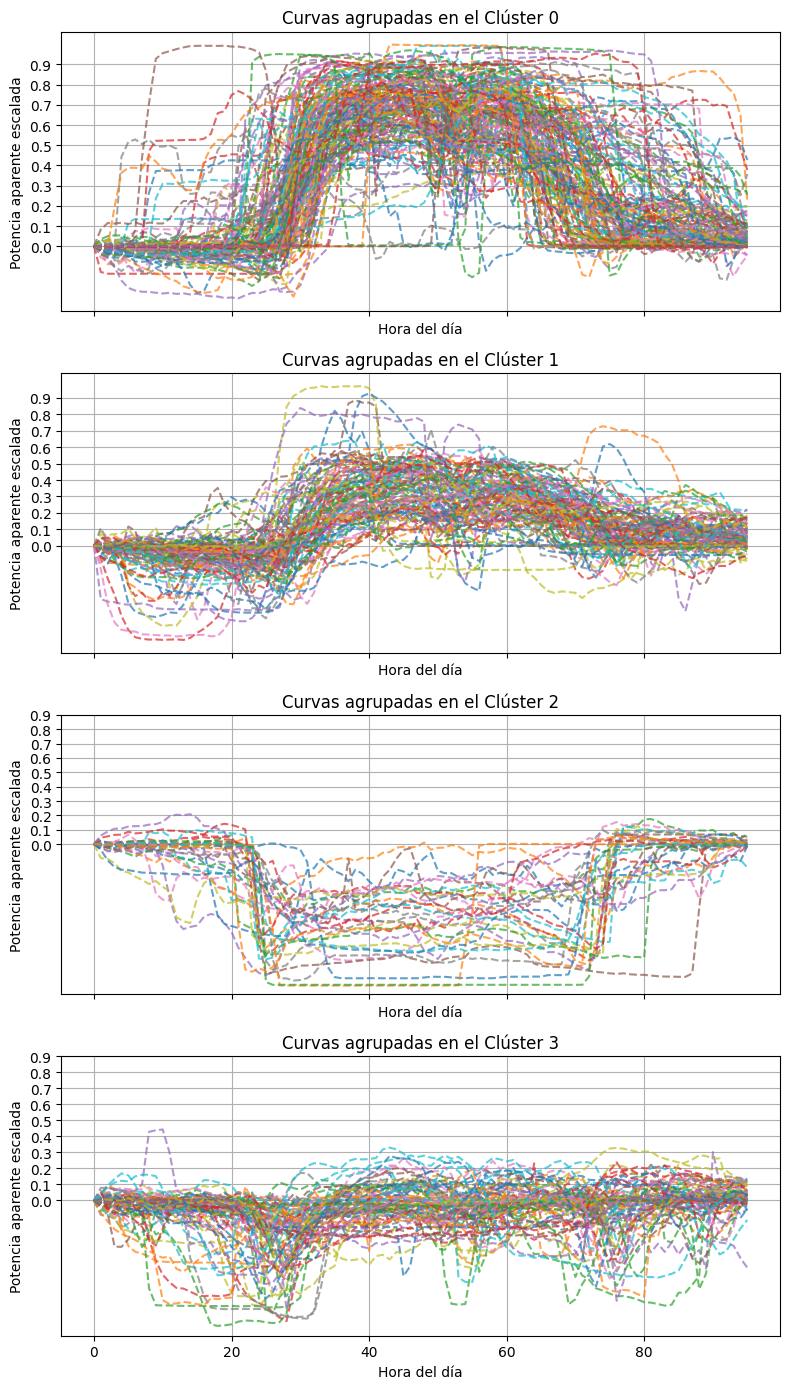

In [229]:
graficar_clusters(curvas_ajustadas_origen, clusters["Birch"], 200)

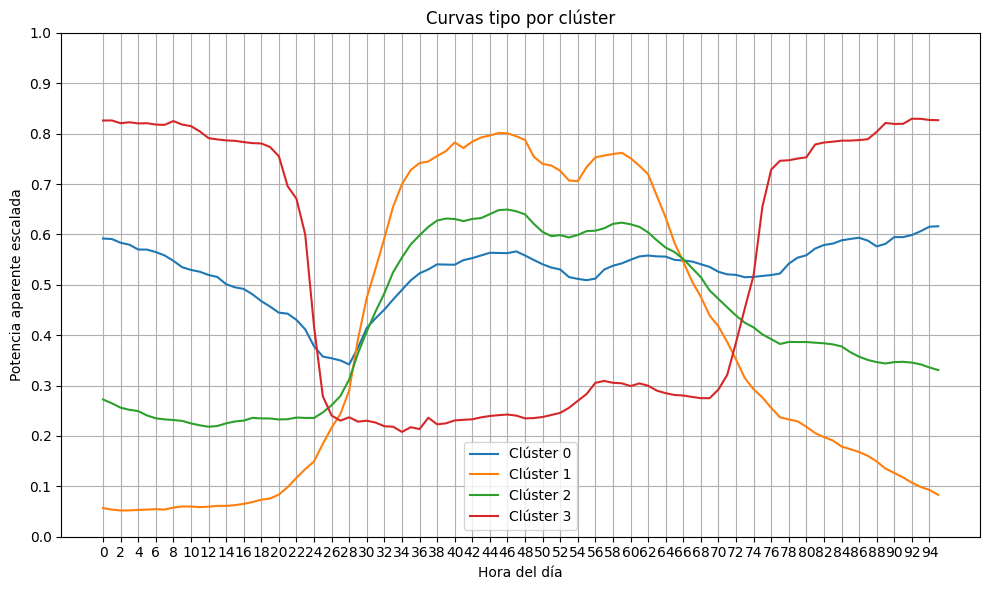

In [230]:
graficar_curva_tipo_cluster(curves_data, clusters["SpectralClustering"])

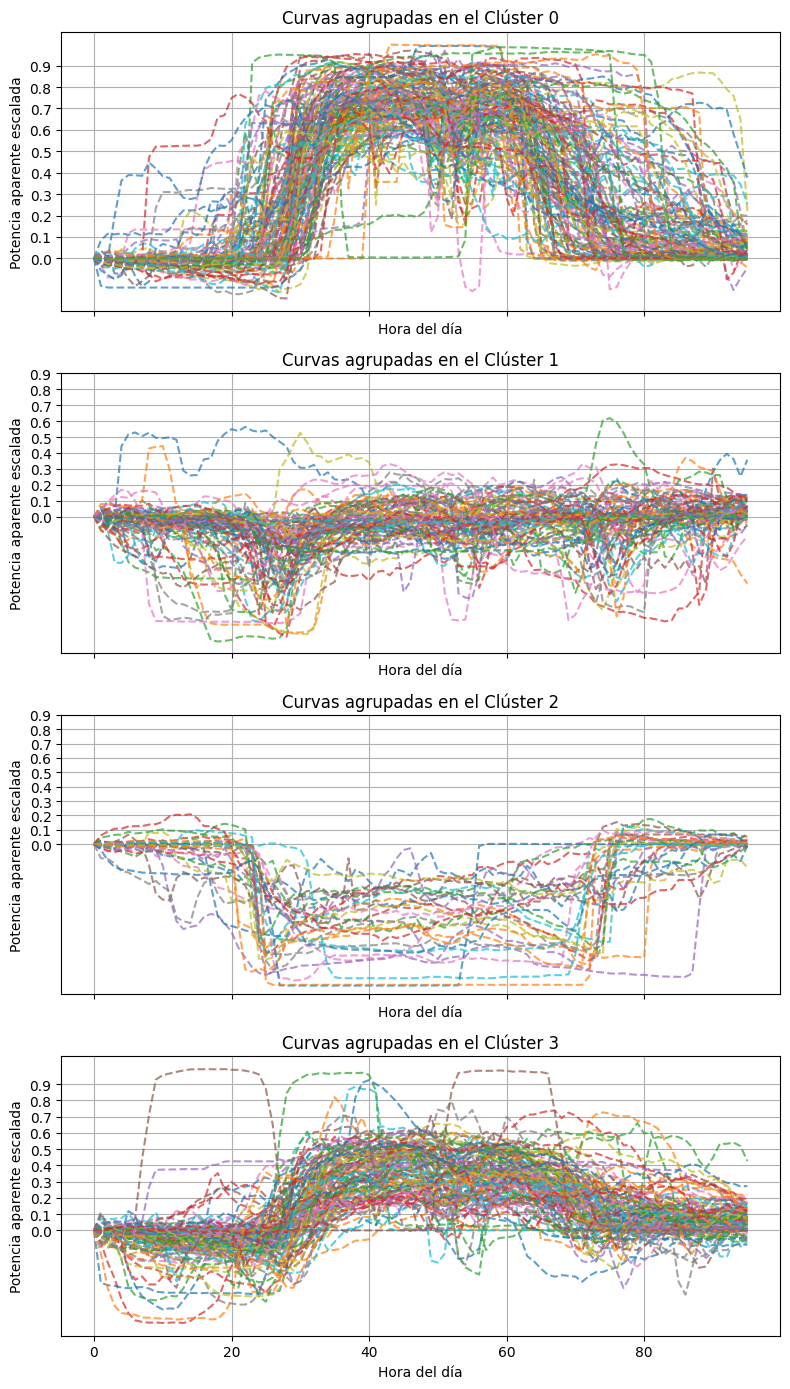

In [179]:
graficar_clusters(curvas_ajustadas_origen, clusters["SpectralClustering"], 200)

### 6.- Comparación de Algoritmos
Se construirá una **tabla comparativa** que contendrá los siguientes indicadores de desempeño:

- **Silhouette Score**
- **SSE (Suma de Errores Cuadráticos)**
- **DBI (Índice de Davies-Bouldin)**
- **CHI (Índice de Calinski-Harabasz)**

In [231]:
df_evaluacion_algoritmos = evaluar_clustering(curvas_ajustadas_origen, clusters)
df_evaluacion_algoritmos

Métrica      KMeans  GaussianMixture  \
0                    Silhouette Score    0.262699         0.264250   
1                                 SSE  980.580706       980.505193   
2                Davies-Bouldin Index    1.159685         1.158655   
3             Calinski-Harabasz Index  279.897240       279.928628   
4  Correlación intra-clúster promedio    0.744779         0.744256   

         Birch  SpectralClustering  
0     0.244961            0.261927  
1  1022.978542          998.581162  
2     1.187626            1.168384  
3   263.005559          272.550480  
4     0.742434            0.747958

---

### 7.- Generar carpetas por algoritmo y clúster asignado

In [232]:
def generar_carpetas_algoritmos_x_cluster(dict_clusters, df_registros_curvas, path_salida = r"../outputs/clusters_x_algoritmos"):

    # Iterar sobre cada algoritmo utilizado
    for algoritmo in list(dict_clusters.keys()):
        # Obtener los números únicos de cluster e iterar sobre cada uno
        for num_cluster in np.unique(dict_clusters[algoritmo]):
            # Verificar si existe, y si no es el caso, crearlo
            if not os.path.exists(os.path.join(path_salida,algoritmo,str(num_cluster))):
                # Crear el directorio si no existe
                os.makedirs(os.path.join(path_salida,algoritmo,str(num_cluster)), exist_ok=True)

    unido = []

    # Iterar sobre cada algoritmo y los clústers asignados
    for algoritmo, _ in dict_clusters.items():

        # Concatenar en un solo arreglo [[cliente, cluster_algoritmoXYZ_asignado]]
        unido = np.concatenate([df_registros_curvas.iloc[:,0].values.reshape(-1,1), dict_clusters[algoritmo].reshape(-1,1)], axis=1)

        # Iterar sobre cada fila del arreglo concatenado
        for fila in unido:
            cliente, cluster = fila[0], fila[1]
            destino = f"../outputs/clusters_x_algoritmos/{algoritmo}/{cluster}/{cliente}"

            if os.path.exists(destino):
                shutil.rmtree(destino)  # Elimina la carpeta y todo su contenido

            # Copiar el entregable a la nueva carpeta
            shutil.copytree(f"../outputs/entregables_por_cliente/{cliente}", destino)

In [234]:
def generar_curvas_tipo_carpetas(path_curvas_algoritmo_cluster="../outputs/clusters_x_algoritmos"):

    # Iterar sobre la carpeta de cada algoritmo
    for algoritmo in list(os.scandir(path_curvas_algoritmo_cluster)):
        # Construir el path /path_curvas_algoritmo_cluster/nombre_algoritmo
        path_algoritmo = os.path.join(path_curvas_algoritmo_cluster, algoritmo.name)

        for n_cluster in list(os.scandir(path_algoritmo)):
            df_concat = pd.DataFrame() # Solo para inicializar, aquí vamos a concatenar todos los datos de curvas tipo de los clientes
                                       # del cluster X del algoritmo Y
            # Construir el path de los archivos del cliente /path_curvas_algoritmo_cluster/nombre_algoritmo/n_cluster
            path_n_cluster = os.path.join(path_curvas_algoritmo_cluster, algoritmo.name, n_cluster.name)

            for cliente in list(os.scandir(path_n_cluster)):
                if not cliente.name.endswith('.png') and not cliente.name.endswith('.csv'):
                    # Leer el archivo que contiene la curva tipo del cliente
                    df_curva_tipo = pd.read_csv(os.path.join(path_n_cluster, cliente.name, f"datos_curva_tipo_{cliente.name}.csv"))

                    # Concatenar los datos del cliente
                    df_concat = pd.concat([df_concat, df_curva_tipo])

            # Agrupar, agregar y generar el gráfico de la curva tipo
            grouped = df_concat.groupby("Hora", as_index=False)["Potencia_aparente_escalada"].apply(np.mean)
            generar_grafica(grouped, path_n_cluster, n_cluster.name, algoritmo.name)


def generar_grafica(df, path, n_cluster, algoritmo):
    
    # Generar la figura
    _ = plt.figure(figsize=(16, 6))
    _ = plt.plot(df["Hora"], df["Potencia_aparente_escalada"], marker='o', color='b', linestyle='-', label='Potencia Aparente Escalada')
    _ = plt.title(f'Curva tipo para clúster #{n_cluster} del algoritmo {algoritmo}')
    _ = plt.xlabel('Hora')
    _ = plt.ylabel('Potencia Aparente Escalada')
    _ = plt.grid(True)

    # Rotar etiquetas para que no se vea acumulado el eje X
    _ = plt.xticks(df["Hora"].values[::2], rotation=45)

    # Para que no se distorsione la dimenisión del eje Y
    _ = plt.yticks(np.arange(0, 1.1, 0.1))

    # Evitar recortes en las etiquetas
    _ = plt.tight_layout()

    # Guardar la gráfica en un directorio
    _ = plt.savefig(f"{path}/curva_tipo_cluster{n_cluster}_{algoritmo}.png", format='png')  # Puedes cambiar el formato a 'jpg', 'pdf', etc.

    # Guardar las coordenadas de la curva tipo como .csv
    df.to_csv(f"{path}/curva_tipo_cluster{n_cluster}_{algoritmo}.csv", index=False)

    # Cerrar la figura
    _ = plt.close()

In [235]:
generar_carpetas_algoritmos_x_cluster(clusters, df_registros_curvas)

In [111]:
generar_curvas_tipo_carpetas()